Imports

In [1]:
import numpy as np

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
from torch.autograd import Variable

**Load and prepare data**

The IMDB sentiment classification dataset consists of 50,000 movie reviews from IMDB users that are labeled as either positive (1) or negative (0). The reviews are preprocessed and each one is encoded as a sequence of word indexes in the form of integers. The words within the reviews are indexed by their overall frequency within the dataset. For example, the integer “2” encodes the second most frequent word in the data. The 50,000 reviews are split into 25,000 for training and 25,000 for testing.

Fortunately, the IMDB dataset has already been built in Keras. Since we want to avoid a 50/50 train test split, we will immediately merge the data into data and targets after downloading so we can do an 80/20 split later on.


In [2]:
print('Loading data...')

#Maximum number of words
max_features = 20000

(train_data, train_label), (test_data, test_label) = imdb.load_data(num_words=max_features)
data = np.concatenate((train_data, test_data), axis=0)
targets = np.concatenate((train_label, test_label), axis=0)
maxlen = 100

# The data must be the same length to enter as the input of our recursive neural network.
X = pad_sequences(data, maxlen=maxlen)

# split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2)

print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
x_train shape: (40000, 100)
x_test shape: (10000, 100)


Now it is time to build a very simple recursive model. Use the embedding layer as the first layer.You can see more information about this layers in the following link. You are not allowed to use LSTM in this exercise.

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

# Model

In [3]:
class RNN_Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        #self.fc2 = nn.Sigmoid()
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        #######
        #tmp = self.fc(hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

## Hyper parameters

In [4]:
# Define hyperparameters
n_epochs = 20
lr = 0.001

# make model
INPUT_DIM = len(X_train)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
BATCH_SIZE = 100

model = RNN_Model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
# Define Loss, Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

## Run faster on GPU

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

print(device)

cuda


## Evaluate function

In [6]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    #rounded_preds = torch.round(preds)

    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [45]:
def evaluate(model, iterator, labels, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(iterator).squeeze(1)

            loss = criterion(predictions, labels.float())

            acc = binary_accuracy(predictions, labels.float())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / 100.0, epoch_acc / 100.0

Train your model with training data, then report the model result on the test data.

In [9]:
# Train your model
def train(model, iterator, labels, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    #for batch in iterator:
        
    optimizer.zero_grad()

    predictions = model(iterator).squeeze(1)
    
    
    loss = criterion(predictions, labels.float())

    acc = binary_accuracy(predictions, labels)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
    return epoch_loss / 100 , epoch_acc / 100


In [32]:
import matplotlib.pyplot as plt

# RUN

In [31]:
# main

best_valid_loss = float('inf')

train_accuracy_history = []
test_accuracy_history = []
train_loss_history = []
test_loss_history = []

for epoch in range(n_epochs):

    valid_loss_epoch = []
    valid_acc_epoch = []

    for i in range(1, X_train.shape[0]//BATCH_SIZE+1):
        train_iterator = X_train[(i-1)*BATCH_SIZE:i*BATCH_SIZE]
        train_labels = y_train[(i-1)*BATCH_SIZE:i*BATCH_SIZE]
        
        test_iterator = X_test[(i-1)*BATCH_SIZE:i*BATCH_SIZE]
        test_labels = y_test[(i-1)*BATCH_SIZE:i*BATCH_SIZE]
        
        
        # Casting
        train_iterator = torch.from_numpy(train_iterator)
        train_labels = torch.from_numpy(train_labels)
        
        test_iterator = torch.from_numpy(test_iterator)
        test_labels = torch.from_numpy(test_labels)
        
        # to cuda
        train_iterator = train_iterator.to(device)
        train_labels = train_labels.to(device)
        test_iterator = test_iterator.to(device)
        test_labels = test_labels.to(device)

        train_loss, train_acc = train(model, train_iterator , train_labels, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, test_iterator, test_labels, criterion)
        
        
    

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
        

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.5f} | Train Acc: {train_acc:.3f}%')
    print(f'\t Val. Loss: {valid_loss:.5f} |  Val. Acc: {valid_acc:.3f}%')
    
    # save results:
    train_accuracy_history.append(train_acc)
    test_accuracy_history.append(valid_acc)
    train_loss_history.append(train_loss)
    test_loss_history.append(valid_loss)

Epoch: 01
	Train Loss: 0.34900 | Train Acc: 0.840%
	 Val. Loss: 0.72918 |  Val. Acc: 0.640%
Epoch: 02
	Train Loss: 0.33874 | Train Acc: 0.830%
	 Val. Loss: 0.53442 |  Val. Acc: 0.715%
Epoch: 03
	Train Loss: 0.52163 | Train Acc: 0.740%
	 Val. Loss: 0.51246 |  Val. Acc: 0.710%
Epoch: 04
	Train Loss: 0.56530 | Train Acc: 0.670%
	 Val. Loss: 0.41860 |  Val. Acc: 0.685%
Epoch: 05
	Train Loss: 0.53509 | Train Acc: 0.750%
	 Val. Loss: 0.40289 |  Val. Acc: 0.690%
Epoch: 06
	Train Loss: 0.48972 | Train Acc: 0.740%
	 Val. Loss: 0.41182 |  Val. Acc: 0.715%
Epoch: 07
	Train Loss: 0.46880 | Train Acc: 0.760%
	 Val. Loss: 0.38921 |  Val. Acc: 0.740%
Epoch: 08
	Train Loss: 0.45999 | Train Acc: 0.780%
	 Val. Loss: 0.40929 |  Val. Acc: 0.765%
Epoch: 09
	Train Loss: 0.41135 | Train Acc: 0.810%
	 Val. Loss: 0.38161 |  Val. Acc: 0.740%
Epoch: 10
	Train Loss: 0.39016 | Train Acc: 0.790%
	 Val. Loss: 0.37974 |  Val. Acc: 0.775%
Epoch: 11
	Train Loss: 0.36108 | Train Acc: 0.830%
	 Val. Loss: 0.37826 |  Val. 

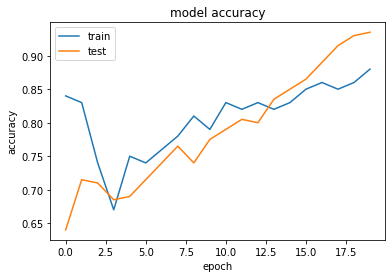

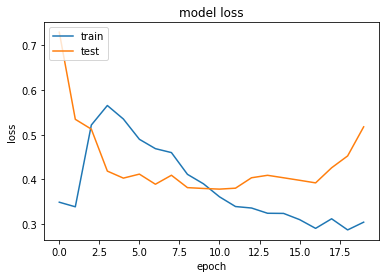

In [43]:
# Plot
# summarize history for accuracy
plt.plot(train_accuracy_history)
plt.plot(test_accuracy_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test Results

In [44]:
# Predict your model on test data
model.load_state_dict(torch.load('tut1-model.pt'))

test_iterator = X_test[(2)*BATCH_SIZE:2*BATCH_SIZE]
test_labels = y_test[(2)*BATCH_SIZE:2*BATCH_SIZE]

test_loss, test_acc = evaluate(model, test_iterator, test_labels, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')


Test Loss: 0.532 | Test Acc: 0.86%
